In [1]:
import os
import zipfile
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load url content into soup
url = 'https://s3.amazonaws.com/tripdata/'

r = requests.get(url)
soup = BeautifulSoup(r.text, 'xml')

In [3]:
# extract file names from soup
files = soup.find_all('Key')
clean_files = []
for i in range(len(files)-1):
    clean_files.append(files[i].get_text())

In [ ]:
# download & unzip data files
for file in clean_files:
    file_url = url + file
    with open(file, "wb") as f:
            response = requests.get(file_url)
            f.write(response.content)
    # unzip data files
    with zipfile.ZipFile(file, "r") as zip_ref:
        zip_ref.extractall("tripdata")        
    # remove zipped file after unziping
    os.remove(file)
os.rmdir('tripdata/__MACOSX')

In [ ]:
# rename files 
directory = 'tripdata/'
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        new_filename = filename.replace(' ','').lower().split('ci', 1)[0].strip('-').replace('-','_')
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename + '.csv'))

In [4]:
#load into dfs (use when files have alredy been downloaded & renamed)
directory = 'tripdata/'
dfs = {}

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        dfs[filename.split('.')[0]] = pd.read_csv(os.path.join(directory, filename)) 

In [5]:
#make column names consistent across all dfs
col_names = ['trip_duration', 'start_time', 'stop_time', 'start_station_id', 'start_station_name', 'start_station_lat',
             'start_station_long', 'end_station_id', 'end_station_name', 'end_station_lat', 'end_station_long',
             'bike_id', 'user_type', 'birth_year', 'gender']

for df in dfs.values():
    df.columns = col_names

In [6]:
# iterate over dfs changing dates to datetime
for df in dfs.values():
    df.start_time =  pd.to_datetime(df.start_time, format='%m/%d/%Y %H:%M:%S', errors='ignore')
    df.start_time =  pd.to_datetime(df.start_time, format='%m/%d/%Y %H:%M', errors='ignore')
    df.start_time =  pd.to_datetime(df.start_time, format='%Y-%m-%d %H:%M:%S', errors='ignore')
    df.stop_time =  pd.to_datetime(df.stop_time, format='%m/%d/%Y %H:%M:%S', errors='ignore')
    df.stop_time =  pd.to_datetime(df.stop_time, format='%m/%d/%Y %H:%M', errors='ignore')
    df.stop_time =  pd.to_datetime(df.stop_time, format='%Y-%m-%d %H:%M:%S', errors='ignore')

In [56]:
# concatenate all dfs into a single master one
master_df = pd.concat(dfs, ignore_index=True)

In [ ]:
master_df.info()

In [ ]:
master_df.sample(n=10)

In [57]:
# change data types to more appropriate / efficient ones
# downcast trip duration
master_df.trip_duration = pd.to_numeric(master_df.trip_duration, downcast = 'unsigned')

In [58]:
# make birth_year column a float
master_df.birth_year = pd.to_numeric(master_df.birth_year, errors='coerce', downcast='float')

In [59]:
# downcast floats
float_cols = ['start_station_lat', 'start_station_long', 'end_station_lat', 'end_station_long']
for col in float_cols:
    master_df[col] = pd.to_numeric(master_df[col], downcast='float')

In [60]:
# convert appropriate columns to categories
category_cols = ['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'bike_id', 'user_type',
             'gender']
for col in category_cols:
    master_df[col] = master_df[col].astype('category')

In [ ]:
master_df.info()

In [61]:
# replace numeric representation of gender for actual gender
master_df.gender = master_df.gender.replace({0: np.nan, 1: 'male', 2: 'female'}).astype('category')

In [ ]:
master_df.info()

In [62]:
master_df.isna().sum()

trip_duration               0
start_time                  0
stop_time                   0
start_station_id         2677
start_station_name       2677
start_station_lat           0
start_station_long          0
end_station_id          20736
end_station_name        20736
end_station_lat         18059
end_station_long        18059
bike_id                     0
user_type               52277
birth_year            6273717
gender                8980438
dtype: int64

In [64]:
# set start_time as index
master_df.set_index('start_time', inplace=True)

In [65]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86185242 entries, 2016-04-01 00:00:26 to 2016-09-30 23:59:51
Data columns (total 14 columns):
trip_duration         uint32
stop_time             datetime64[ns]
start_station_id      category
start_station_name    category
start_station_lat     float32
start_station_long    float32
end_station_id        category
end_station_name      category
end_station_lat       float32
end_station_long      float32
bike_id               category
user_type             category
birth_year            float32
gender                category
dtypes: category(7), datetime64[ns](1), float32(5), uint32(1)
memory usage: 4.2 GB


In [66]:
master_df.to_pickle('master_df.pickle')

In [ ]:
# Bronx rides
master_df.loc[master_df.start_station_id.isna()]

In [ ]:
master_df.loc[(master_df.end_station_id.isna()) & (master_df.start_station_id.notna())]

In [12]:
df_subset = dfs['201908']

# downcast trip duration
df_subset.trip_duration = pd.to_numeric(df_subset.trip_duration, downcast = 'unsigned')

# make birth_year column a float
df_subset.birth_year = pd.to_numeric(df_subset.birth_year, errors='coerce', downcast='float')

# downcast floats
float_cols = ['start_station_lat', 'start_station_long', 'end_station_lat', 'end_station_long']
for col in float_cols:
    df_subset[col] = pd.to_numeric(df_subset[col], downcast='float')

# convert appropriate columns to categories
category_cols = ['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'bike_id', 'user_type',
             'gender']
for col in category_cols:
    df_subset[col] = df_subset[col].astype('category')
    
# replace numeric representation of gender for actual gender
df_subset.gender = df_subset.gender.replace({0: np.nan, 1: 'male', 2: 'female'}).astype('category')

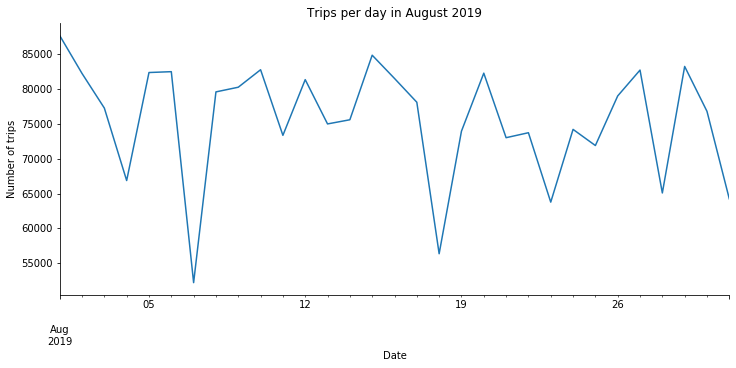

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))

df_subset.resample('D', on='start_time').count()['start_time'].plot()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Trips per day in August 2019')
plt.xlabel('Date')
plt.ylabel('Number of trips');